# Image Classification

***[주의] 본 노트북을 원활히 수행하려면 GPU가 필요합니다.***

본 핸즈온에서는 Kaggle의 Shopee-IET dataset을 사용해서 의류 종류(BabyPants, BabyShirt, womencasualshoes, womenchiffontop)를 구별하는 다중 클래스 분류 모델을 AutoGluon으로 훈련해 보겠습니다.

In [1]:
import os
import autogluon.core as ag
from autogluon.vision import ImagePredictor
CLS_TO_STR = {0:'BabyPants', 1:'BabyShirt', 2:'womencasualshoes', 3:'womenchiffontop'}

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.10.0` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


<br>

## 1. Data Preparation and Training

In [2]:
train_dataset, _, test_dataset = ImagePredictor.Dataset.from_folders('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')
print(train_dataset)

100%|██████████| 40895/40895 [00:02<00:00, 20282.06KB/s]


data/
├── test/
└── train/
                                                 image  label
0    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
1    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
2    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
3    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
4    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
..                                                 ...    ...
795  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
796  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
797  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
798  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
799  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3

[800 rows x 2 columns]


In [3]:
save_path = 'ag-01-img-classification'
!rm -rf $save_path

In [4]:
%%time
predictor = ImagePredictor(path=save_path)
# since the original dataset does not provide validation split, the `fit` function splits it randomly with 90/10 ratio
predictor.fit(train_dataset, hyperparameters={'epochs': 2}) 

`time_limit=auto` set to `time_limit=7200`.
Reset labels to [0, 1, 2, 3]
Randomly split train_data into train[720]/validation[80] splits.
The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
Starting fit without HPO
modified configs(<old> != <new>): {
root.misc.seed       42 != 223
root.train.batch_size 32 != 16
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 2
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.img_cls.model   resnet101 != resnet50
}
Saved config to /home/ec2-user/SageMaker/autogluon-on-aws/3.cv/ag-01-img-classification/c25f076e/.trial_0/config.yaml
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Model resnet50 created, param count:                                         23516228
AMP not enabled. Training in float32

CPU times: user 26.1 s, sys: 4.14 s, total: 30.3 s
Wall time: 34.8 s


<br>

## 2. Prediction and Evaluation

### Prediction

In [5]:
def predict_image(image_path, predictor):
    pred_cls_idx = predictor.predict(image_path)[0]
    pred_cls_score = predictor.predict_proba(image_path)[pred_cls_idx][0]
    pred_cls_str = CLS_TO_STR[pred_cls_idx]
    #pred_cls_str = result['class'][0]
    #pred_cls_score = result['score'][0]
    #pred_cls_idx = result['id'][0]
    import cv2
    import matplotlib.pyplot as plt
    im = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(im, f'{pred_cls_str} {pred_cls_score:.2f}%', (10,40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    plt.figure(figsize=(10, 10))
    plt.imshow(im[:,:,::-1])    

In [6]:
img_idx = 30
image_path = test_dataset.iloc[img_idx]['image']
pred_cls_idx = predictor.predict(image_path)[0]
pred_cls_score = predictor.predict_proba(image_path)[pred_cls_idx][0]
print(pred_cls_idx, pred_cls_score)

1 0.281370609998703


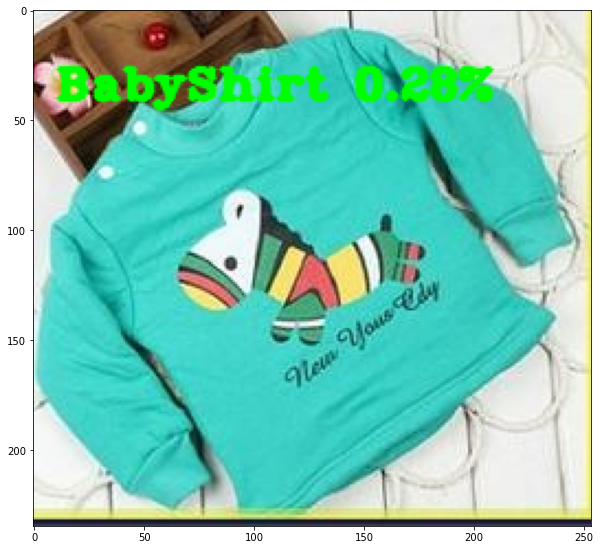

In [7]:
predict_image(image_path, predictor)

### Evaluate on Test Dataset

In [8]:
y_pred = predictor.predict(test_dataset[['image']])
y_pred.tail()

75    3
76    3
77    3
78    3
79    3
Name: label, dtype: int64

In [9]:
predictor.evaluate(test_dataset)

[Epoch 1] validation: top1=0.712500 top5=1.000000


{'loss': 1.2078110218048095, 'top1': 0.7125, 'top5': 1.0}

### Generate image features with a classifier

`predict_feature()`로 입력 이미지에 대한 임베딩 벡터 추출도 쉽게 가능합니다. 아래 코드 예시를 참조해 주세요.

In [10]:
image_path = test_dataset.iloc[30]['image']
feature = predictor.predict_feature(image_path)
print(feature)

                                       image_feature  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                               image  
0  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...  


### Save and load classifiers

In [11]:
filename = os.path.join(save_path, 'predictor.ag')
predictor.save(filename)
predictor_loaded = ImagePredictor.load(filename)
# use predictor_loaded as usual
pred_cls_idx = predictor.predict(image_path)[0]
pred_cls_score = predictor.predict_proba(image_path)[pred_cls_idx][0]
print(pred_cls_idx, pred_cls_score)

1 0.281370609998703
